# Naive Bayes and Logistic Regression

In this tutorial, we'll explore training and evaluation of Naive Bayes and Logitistic Regression Classifiers.

To start, we import the standard BIDMach class definitions. 

In [1]:
import $exec.^.lib.bidmach_notebook_init

2 CUDA devices found, CUDA version 8.0


import $exec.$                          

Now we load some training and test data, and some category labels. The data come from a news collection from Reuters, and is a "classic" test set for classification. Each article belongs to one or more of 103 categories. The articles are represented as Bag-of-Words (BoW) column vectors. For a data matrix A, element A(i,j) holds the count of word i in document j. 

The category matrices have 103 rows, and a category matrix C has a one in position C(i,j) if document j is tagged with category i, or zero otherwise.  

To reduce the computing time and memory footprint, the training data have been sampled. The full collection has about 700k documents. Our training set has 60k. 

Since the document matrices contain counts of words, we use a min function to limit the count to "1", i.e. because we need binary features for naive Bayes. 

In [2]:
val dict = "../data/rcv1/"
val traindata = loadSMat(dict+"docs.smat.lz4")
val traincats = loadFMat(dict+"cats.fmat.lz4")
val testdata = loadSMat(dict+"testdocs.smat.lz4")
val testcats = loadFMat(dict+"testcats.fmat.lz4")
min(traindata, 1, traindata)                       // the first "traindata" argument is the input, the other is output
min(testdata, 1, testdata)

dict: String = "../data/rcv1/"
traindata: SMat = (    33,     0)     1
(    47,     0)     1
(    94,     0)     1
(   104,     0)     1
(   112,     0)     1
(   118,     0)     1
(   141,     0)     1
(   165,     0)     1
(   179,     0)     1
(   251,     0)     1
(   270,     0)     1
(   306,     0)     1
...
traincats: FMat =    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

Get the word and document counts from the data. This turns out to be equivalent to a matrix multiply. For a data matrix A and category matrix C, we want all (cat, word) pairs (i,j) such that C(i,k) and A(j,k) are both 1 - this means that document k contains word j, and is also tagged with category i. Summing over all documents gives us

$${\rm wordcatCounts(i,j)} = \sum_{k=1}^N C(i,k) A(j,k) = C * A^T$$


Because we are doing independent binary classifiers for each class, we need to construct the counts for words not in the class (negwcounts).

Finally, we add a smoothing count 0.5 to counts that could be zero.

In [3]:
val truecounts = traincats *^ traindata
val wcounts = truecounts + 0.5
val negwcounts = sum(truecounts) - truecounts + 0.5
val dcounts = sum(traincats,2)

truecounts: FMat =     6601    6282       0       0    1338    2167    2931     551    3588...
   54661   63593       0       0   35284   30807   30156    7978   40192...
   31637   15944       0       0   18959   36288   35867   36767   18956...
   14443   14678       0       0    7309   14194   16290    1882   11460...
   88680   65557       0       0   54424  117815  119028   40490   68167...
   11592   15108       0       0   14155    3868    5600    3529    2315...
  129559  169595       0       0  164626   66692   95662  143881   53627...
   17642   33419       0       0   39781    6437   11017   51591    7120...
   43411   70692       0       0   69276   26538   31923   89144   15103...
    8301    8799       0       0    5441    4137    3469    1455    2164...
   50537  116171       0       0   53590   36965   30849   18426   31545...
    8300    8901       0       0    5528    4220    3469    1485    2143...
...
wcounts: FMat =       6601.5      6282.5     0.50000     0.50000 

Now compute the probabilities 
* pwordcat = probability that a word is in a cat, given the cat.
* pwordncat = probability of a word, given the complement of the cat.
* pcat = probability that doc is in a given cat. 
* spcat = sum of pcat probabilities (> 1 because docs can be in multiple cats)

In [4]:
val pwordcat = wcounts / sum(wcounts,2)                 // Normalize the rows to sum to 1.
val pwordncat = negwcounts / sum(negwcounts,2)          // Each row represents word probabilities conditioned on one cat. 
val pcat = dcounts / traindata.ncols
val spcat = sum(pcat)

pwordcat: FMat =    0.0068321   0.0065020  5.1747e-07  5.1747e-07   0.0013853   0.0022432...
   0.0055248   0.0064276  5.0537e-08  5.0537e-08   0.0035663   0.0031138...
   0.0071998   0.0036285  1.1379e-07  1.1379e-07   0.0043147   0.0082583...
   0.0065308   0.0066370  2.2608e-07  2.2608e-07   0.0033051   0.0064182...
   0.0061666   0.0045587  3.4768e-08  3.4768e-08   0.0037845   0.0081925...
   0.0044292   0.0057726  1.9104e-07  1.9104e-07   0.0054085   0.0014781...
   0.0055111   0.0072142  2.1269e-08  2.1269e-08   0.0070028   0.0028369...
   0.0050931   0.0096476  1.4434e-07  1.4434e-07    0.011484   0.0018584...
   0.0061113   0.0099519  7.0388e-08  7.0388e-08   0.0097525   0.0037360...
   0.0048131   0.0051018  2.8989e-07  2.8989e-07   0.0031549   0.0023989...
   0.0019538   0.0044912  1.9330e-08  1.9330e-08   0.0020718   0.0014291...
   0.0047402   0.0050834  2.8554e-07  2.8554e-07   0.0031572   0.0024102...
...
pwordncat: FMat =    0.0045730   0.0058350  2.5433e-09  2.5433e-09 

Now take the logs of those probabilities. Here we're using the formula presented <a href="https://bcourses.berkeley.edu/courses/1267848/files/51512989/download?wrap=1in">here</a> to match Naive Bayes to Logistic Regression for independent data.

For each word, we compute the log of the ratio of the complementary word probability over the in-class word probability. 

For each category, we compute the log of the ratio of the complementary category probability over the current category probability.

lpwordcat(j,i) represents $\log\left(\frac{{\rm Pr}(X_i|\neg c_j)}{{\rm Pr}(X_i|c_j)}\right)$

while lpcat(j) represents $\log\left(\frac{{\rm Pr}(\neg c)}{{\rm Pr}(c)}\right)$

In [5]:
val lpwordcat = ln(pwordncat/pwordcat)   // ln is log to the base e (natural log)
val lpcat = ln((spcat-pcat)/pcat)

lpwordcat: FMat =    -0.40147   -0.10823    -5.3155    -5.3155     1.1693    0.45114...
   -0.19705   -0.10100    -2.9423    -2.9423    0.23118    0.12794...
   -0.46455    0.48418    -3.7833    -3.7833   0.030486   -0.88511...
   -0.35877   -0.12979    -4.4811    -4.4811    0.29928   -0.61126...
   -0.32353    0.26497    -2.5441    -2.5441    0.17303   -0.95573...
   0.034805   0.011458    -4.3106    -4.3106   -0.19905    0.87429...
   -0.21170   -0.24378    -2.0018    -2.0018   -0.53518    0.24048...
   -0.10730   -0.51401    -4.0259    -4.0259   -0.97782    0.64592...
   -0.30007   -0.55996    -3.2888    -3.2888   -0.83124  -0.063085...
  -0.049195    0.13595    -4.7322    -4.7322    0.34544    0.38508...
    0.93577    0.29653    -1.8927    -1.8927    0.84083    0.98593...
  -0.033811    0.13960    -4.7169    -4.7169    0.34474    0.38036...
...
lpcat: FMat =   5.7190
  3.0325
  3.9597
  4.5962
  2.4624
  4.3834
  1.7641
  3.4293
  2.7826
  5.0221
  2.2930
  5.0110
...

Here's where we apply Naive Bayes. The formula we're using is borrowed from <a href="https://bcourses.berkeley.edu/courses/1267848/files/51512989/download?wrap=1in">here</a>.

$${\rm Pr}(c|X_1,\ldots,X_k) = \frac{1}{1 + \frac{{\rm Pr}(\neg c)}{{\rm Pr}(c)}\prod_{i-1}^k\frac{{\rm Pr}(X_i|\neg c)}{{\rm Pr}(X_i|c)}}$$

and we can rewrite

$$\frac{{\rm Pr}(\neg c)}{{\rm Pr}(c)}\prod_{i-1}^k\frac{{\rm Pr}(X_i|\neg c)}{{\rm Pr}(X_i|c)}$$

as

$$\exp\left(\log\left(\frac{{\rm Pr}(\neg c)}{{\rm Pr}(c)}\right) + \sum_{i=1}^k\log\left(\frac{{\rm Pr}(X_i|\neg c)}{{\rm Pr}(X_i|c)}\right)\right)  = \exp({\rm lpcat(j)} + {\rm lpwordcat(j,?)} * X)$$

for class number j and an input column $X$. This follows because an input column $X$ is a sparse vector with ones in the positions of the input features. The product ${\rm lpwordcat(i,?)} * X$ picks out the features occuring in the input document and adds the corresponding logs from lpwordcat. 

Finally, we take the exponential above and fold it into the formula $P(c_j|X_1,\ldots,X_k) = 1/(1+\exp(\cdots))$. This gives us a matrix of predictions. preds(i,j) = prediction of membership in category i for test document j. 

In [6]:
val logodds = lpwordcat * testdata + lpcat
val preds = 1 / (1 + exp(logodds))

logodds: FMat =    -6.0932    82.044    57.881    57.881    46.718    63.467    43.108...
    10.183    17.738    36.602    36.602    22.135    45.008    24.703...
   -30.983    96.652    46.998    46.998    62.005    20.090   -74.427...
   -25.657    108.47    86.850    86.850    62.880    33.790   -29.653...
   -33.350    69.578    58.679    58.679    59.652   -65.415   -70.871...
    78.985   -22.122    34.228    34.228    21.171    34.943    111.26...
    36.580   -22.600   -30.684   -30.684   -2.4677    30.346    50.377...
    92.823    85.826  -0.92882  -0.92882    35.390    113.61    124.14...
    40.340    45.135   -29.260   -29.260    25.949    71.048    57.417...
    48.189    14.777    32.442    32.442    32.825    70.634    87.507...
    62.109    47.123    58.016    58.016    5.9495    89.868    117.45...
    50.110    13.168    32.410    32.410    32.537    72.225    92.823...
...
preds: FMat =      0.99775  2.3386e-36  7.2888e-26  7.2888e-26  5.1342e-21  2.7320e-28...
  

To measure the accuracy of the predictions above, we can compute the probability that the classifier outputs the right label. We used this formula in class for the expected accuracy for logistic regression. The "dot arrow" operator takes dot product along rows:

In [7]:
val acc = ((preds ∙→ testcats) + ((1-preds) ∙→ (1-testcats)))/preds.ncols
acc.t

acc: FMat =   0.96676
  0.91988
  0.92873
  0.90522
  0.92503
  0.92083
  0.87694
  0.93186
  0.91148
  0.97116
  0.93154
  0.97145
...
res6_1: FMat = 0.96676,0.91988,0.92873,0.90522,0.92503,0.92083,0.87694,0.93186,0.91148,0.97116,0.93154,0.97145,0.89068,0.97366,0.96644,0.93150,0.93144,0.99561,0.96318,0.90782,0.91158,0.88406,0.97971,0.94595,0.94944,0.91045,0.90866,0.89464,0.96982,0.96171,0.93822,0.97635,0.97523,0.90473,0.92854,0.85144,0.90741,0.96143,0.98985,0.99624,0.98202,0.97888,0.99910,0.93597,0.90695,0.98017,0.96474,0.97071,0.96489,0.92164,0.99069,0.97455,0.96476,0.90273,0.97072,0.98506,0.98083,0.99524,0.97665,0.99359,0.96843,0.98735,0.97673,0.99521,0.98967,0.99410,0.93016,0.99611,0.99480,0.99684,0.99672,0.96849,0.99729,0.97603,0.96933,0.98094,0.99288,0.99335,0.99803,0.90614,0.99000,0.99077,0.99327,0.96843,0.95881,0.99586,0.99706,0.92778,0.99615,0.99851,0.99031,0.99615,0.99574,0.99295,0.99623,0.99870,0.99871,0.99938,0.99944,0.99869,0.99881,0.99952,0.99978

Raw accuracy is not a good measure in most cases. When there are few positives (instances in the class vs. its complement), accuracy simply drives down false-positive rate at the expense of false-negative rate. In the worst case, the learner may always predict "no" and still achieve high accuracy. 

ROC curves and ROC Area Under the Curve (AUC) are much better. Here we compute the ROC curves from the predictions above. We need:
* scores - the predicted quality from the formula above.
* good - 1 for positive instances, 0 for negative instances.
* bad - complement of good. 
* npoints (100) - specifies the number of X-axis points for the ROC plot. 

itest specifies which of the categories to plot for. We chose itest=6 because that category has one of the highest positive rates, and gives the most stable accuracy plots.  

In [8]:
val itest = 6
val scores = preds(itest,?)
val good = testcats(itest,?)
val bad = 1-testcats(itest,?)
val rr =roc(scores,good,bad,100)

itest: Int = 6
scores: FMat = 1.2985e-16,1,1,1,0.92184,6.6234e-14,1.3227e-22,1.0000,6.4175e-05,0.74290,0.091579,2.8002e-11,4.0427e-22,0.29289,0.99790,0.0054418,0.99997,2.7469e-31,1.1725e-10,0.015976,0.95969,7.5308e-10,2.9457e-16,0.011309,9.1842e-10,2.0738e-05,3.0239e-30,3.6126e-07,2.0369e-06,1,1,0.99999,0.99999,9.8394e-11,0.81547,0.99826,5.4711e-12,0.99052,4.8879e-10,3.0592e-06,0.99899,1.0000,2.0468e-06,0.99994,0.99781,0.97165,0.0045558,0.021813,1.1182e-17,1.1182e-17,7.6746e-17,1.0000,7.6746e-17,7.3089e-06,7.3089e-06,0.99864,2.8267e-09,1.2181e-14,1,4.7808e-24,2.3243e-24,9.4091e-14,0.99724,7.0307e-08,0.99816,1.3932e-13,1.2951e-08,0.91334,6.3677e-06,5.1386e-10,3.3876e-17,1.0000,1.0000,0.99958,7.8813e-06,1.4805e-12,0.99981,0.99971,8.4397e-11,0.99939,0.99836,1,7.2057e-08,0.010264,1.0000,0.044583,8.8276e-08,6.1791e-13,0.017260,0.99966,0.0021901,4.3284e-17,0.99996,0.99821,0.93932,0.98340,4.8482e-24,1.3503e-11,2.3761e-06,0.99011,0.00018747,1,0.99882,0.98596,0.99655,0.0012145,1.5212e...
good: 

> TODO 1: In the cell below, write an expression to derive the ROC Area under the curve (AUC) given the curve rr. rr gives the ROC curve y-coordinates at 100 evenly-spaced X-values from 0 to 1.0. 

In [8]:
// auc = 

> TODO 2: In the cell below, write the value of AUC returned by the expression above.

## Logistic Regression

Now lets train a logistic classifier on the same data. BIDMach has an umbrella classifier called GLM for Generalized Linear Model. GLM includes linear regression, logistic regression (with log accuracy or direct accuracy optimization), and SVM. 

The learner function accepts these arguments:
* traindata: the training data in the same format as for Naive Bayes
* traincats: the training category labels
* testdata: the test input data
* predcats: a container for the predictions generated by the model
* modeltype (GLM.logistic here): an integer that specifies the type of model (0=linear, 1=logistic log accuracy, 2=logistic accuracy, 3=SVM). 

We'll construct the learner and then look at its options:

In [9]:
val predcats = zeros(testcats.nrows, testcats.ncols)
val (mm,mopts) = GLM.learner(traindata, traincats, GLM.maxp)
mopts.what

Option Name       Type          Value
===========       ====          =====
addConstFeat      boolean       false
aopts             Opts          null
autoReset         boolean       true
batchSize         int           10000
checkPointFile    String        null
checkPointInterval  float         0.0
clipByValue       float         -1.0
cumScore          int           0
debug             int           0
debugCPUmem       boolean       false
debugMem          boolean       false
dim               int           256
doAllReduce       boolean       false
doubleScore       boolean       false
doVariance        boolean       false
epsilon           float         1.0E-5
evalStep          int           11
featThreshold     Mat           null
featType          int           1
gsq_decay         float         -1.0
hashBound1        int           1000000
hashBound2        int           1000000
hashFeatures      int           0
initsumsq         float         1.0E-5
iweight           FMat          n

predcats: FMat =    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0...
...
mm: Learner = BIDMach.Learner@54c2c0e7
mopts: GLM.LearnOptions = BI

The most important options are:
* lrate: the learning rate
* batchSize: the minibatch size
* npasses: the number of passes over the dataset

We'll use the following parameters for this training run. 

In [10]:
mopts.lrate=1.0
mopts.batchSize=1000
mopts.npasses=2
mopts.autoReset = false
mm.train

corpus perplexity=81528.088805


00:19:16 INFO: pass= 0
00:19:17 INFO:  1.00%, score=-0.50000, secs=0.5, samps/s=16427.1, gf= 4.9, MB/s=17.62, GPUmem=0.886633
00:19:17 INFO:  2.00%, score=-0.02578, secs=0.6, samps/s=27491.4, gf= 8.7, MB/s=29.06, GPUmem=0.886633
00:19:17 INFO:  3.00%, score=-0.02423, secs=0.7, samps/s=34782.6, gf=11.2, MB/s=36.57, GPUmem=0.886633
00:19:17 INFO:  4.00%, score=-0.02123, secs=0.8, samps/s=43156.6, gf=14.2, MB/s=45.34, GPUmem=0.886633
00:19:17 INFO:  5.00%, score=-0.02148, secs=0.9, samps/s=49197.9, gf=16.4, MB/s=51.70, GPUmem=0.886633
00:19:17 INFO:  7.00%, score=-0.02072, secs=1.0, samps/s=54337.5, gf=18.3, MB/s=57.13, GPUmem=0.886633
00:19:17 INFO:  8.00%, score=-0.02275, secs=1.2, samps/s=58469.5, gf=19.7, MB/s=61.38, GPUmem=0.886633
00:19:17 INFO: 10.00%, score=-0.02079, secs=1.3, samps/s=61912.2, gf=21.0, MB/s=65.11, GPUmem=0.886633
00:19:17 INFO: 11.00%, score=-0.02122, secs=1.4, samps/s=64748.2, gf=22.0, MB/s=68.01, GPUmem=0.886633
00:19:18 INFO: 12.00%, score=-0.02124, secs=1.5, s

00:19:25 INFO: 11.00%, score=-0.01431, secs=9.4, samps/s=92383.1, gf=31.8, MB/s=95.50, GPUmem=0.886469
00:19:26 INFO: 12.00%, score=-0.01575, secs=9.5, samps/s=92441.9, gf=31.9, MB/s=95.52, GPUmem=0.886469
00:19:26 INFO: 14.00%, score=-0.01429, secs=9.7, samps/s=92499.2, gf=31.9, MB/s=95.56, GPUmem=0.886469
00:19:26 INFO: 15.00%, score=-0.01219, secs=9.8, samps/s=92564.7, gf=31.9, MB/s=95.59, GPUmem=0.886469
00:19:26 INFO: 17.00%, score=-0.01502, secs=9.9, samps/s=92619.4, gf=31.9, MB/s=95.61, GPUmem=0.886469
00:19:26 INFO: 18.00%, score=-0.01174, secs=10.0, samps/s=92672.8, gf=31.9, MB/s=95.66, GPUmem=0.886469
00:19:26 INFO: 19.00%, score=-0.01562, secs=10.1, samps/s=92725.1, gf=32.0, MB/s=95.70, GPUmem=0.886469
00:19:26 INFO: 21.00%, score=-0.01566, secs=10.2, samps/s=92785.2, gf=32.0, MB/s=95.69, GPUmem=0.886469
00:19:26 INFO: 22.00%, score=-0.01361, secs=10.3, samps/s=92835.1, gf=32.0, MB/s=95.73, GPUmem=0.886469
00:19:26 INFO: 24.00%, score=-0.01250, secs=10.4, samps/s=92875.0, gf

In [11]:
val (nn, nopts) = GLM.predictor(mm.model, testdata)

nn.predict

corpus perplexity=115510.898502


nn: Learner = BIDMach.Learner@7673c34c
nopts: GLM.PredOptions = BIDMach.models.GLM$PredOptions@65dcb612
res10_1: FMat =      0     0     0     0     0     0     0     0     0     0     0     0...
   772  1544  2316  3088  3860  4632  5404  6176  6948  7720  8492  9264...


In [12]:
val predcats = FMat(nn.preds(0))
val lacc = (predcats ∙→ testcats + (1-predcats) ∙→ (1-testcats))/preds.ncols
lacc.t
mean(lacc)

predcats: FMat =   2.0390e-31           0  1.5414e-32  1.5414e-32  8.0951e-15           0...
   0.0069917  1.4453e-14  1.7498e-11  1.7498e-11  6.0095e-05  1.4591e-22...
     0.99655  7.0360e-21  3.1158e-16  3.1158e-16  1.6628e-08  4.7719e-14...
  5.6964e-30           0  5.4361e-32  5.4361e-32  1.4166e-14  2.2035e-35...
           1  2.9218e-13  5.2180e-22  5.2180e-22  1.1321e-11           1...
  3.5295e-31           0  2.7782e-32  2.7782e-32  4.4355e-15  6.3061e-35...
  1.8177e-13           1           1           1     0.99800  3.0332e-12...
  1.9986e-21  8.0684e-29  5.0547e-13  5.0547e-13  4.0137e-11  3.1115e-28...
  2.1465e-16  1.6936e-22     0.99995     0.99995  1.0668e-10  1.1596e-21...
  2.9865e-31           0  2.1006e-32  2.1006e-32  8.4742e-15           0...
  3.9151e-19  4.6547e-23  8.9845e-13  8.9845e-13  1.0123e-05  1.4977e-25...
  3.4177e-31           0  2.9459e-32  2.9459e-32  1.2208e-14           0...
...
lacc: FMat =   0.98791
  0.94737
  0.98871
  0.96870
  0.96625
  0.

Since we have the accuracy scores for both Naive Bayes and Logistic regression, we can plot both of them on the same axes. Naive Bayes is red, Logistic regression is blue. The x-axis is the category number from 0 to 102. The y-axis is the absolute accuracy of the predictor for that category. 

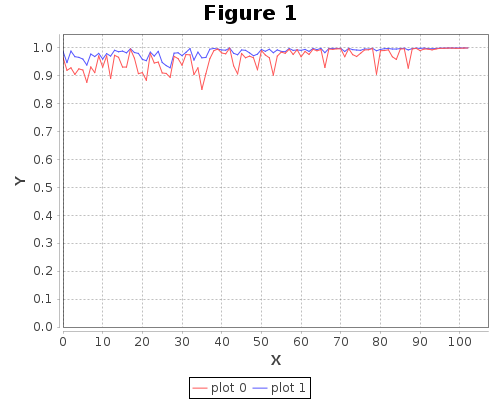

axaxis: FMat = 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102

In [13]:
val axaxis = row(0 until 103)
plot(axaxis, acc, axaxis, lacc)

> TODO 3: With the full training set (700k training documents), Logistic Regression is noticeably more accurate than Naive Bayes in every category. What do you observe in the plot above? Why do you think this is?

Next we'll compute the ROC plot and ROC area (AUC) for Logistic regression  for category itest.

In [14]:
val lscores = predcats(itest,?)
val lrr =roc(lscores,good,bad,100)
val auc = mean(lrr)                           // Fill in using the formula you used before

lscores: FMat = 1.8177e-13,1,1,1,0.99800,3.0332e-12,0,1,0.88480,1,0.99999,1.0970e-16,7.0726e-19,1,0.45068,3.7902e-08,1,2.3382e-20,7.5716e-07,1,1,1.7385e-10,4.2914e-15,1,1.6561e-05,1,1.9739e-22,1,4.6652e-09,1,0.99975,1,1,6.0667e-15,0.61837,1,5.4842e-08,1,1.4422e-12,3.7628e-10,0.99968,1,1,1.0000,0.99999,1,1,0.017378,1.0841e-17,1.0841e-17,2.4883e-20,1,2.4883e-20,8.3366e-13,8.3366e-13,0.0053147,1.0000,3.0660e-16,1,8.6814e-20,5.4920e-21,9.6985e-09,1,1.2030e-06,1,3.3140e-20,5.4059e-16,0.99783,0.57497,1.0000,1.1233e-06,1,1,1.0000,1,4.0598e-10,1,1,2.4461e-15,1.0000,0.99995,1,1.2981e-16,0.98611,1,0.99947,5.0567e-12,6.4540e-14,8.5891e-11,1.0000,7.0400e-08,1.0203e-14,1,1.0000,0.99993,1.0000,2.2480e-19,1.0775e-07,1.4156e-12,1.0000,0.78571,1,1,0.99977,1,0.0017367,0,1,3.0140e-15,1.0000,1,2.1137e-14,5.2942e-09,0.99996,7.0595e-21,1,1,1,1,3.5363e-17,0.037261,1,1,8.8509e-07,8.0993e-08,0.99997,1.0000,1.7241e-10,1,3.5471e-23,3.7142e-06,1,1,1.0000,5.1677e-16,2.9611e-10,9.6717e-15,1,...
lrr: DMat =         

We computed the ROC curve for Naive Bayes earlier, so now we can plot them on the same axes. Naive Bayes is once again in red, Logistic regression in blue. 

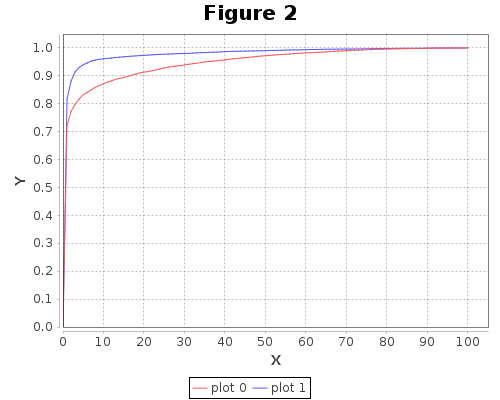

rocxaxis: FMat = 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100

In [15]:
val rocxaxis = row(0 until 101)
plot(rocxaxis, rr, rocxaxis, lrr)

>TODO 4: In the cell below, compute and plot lift curves from the ROC curves for Naive Bayes and Logistic regression. The lift curves should show the ratio of ROC y-values over a unit slope diagonal line (Y=X). The X-values should be the same as for the ROC plots, except that X=0 will be omitted since the lift will be undefined. 

> TODO 5: Experiment with different values for learning rate and batchSize to get the best performance for absolute accuracy and ROC area on category 6. Write your optimal values below: